# Оптимизация производственных расходов металлургического комбината «Стальная птица»

## Описание проекта

Комбинату необходимо уменьшить потребление электроэнергии на этапе обработки стали. Для этого нужно контролировать температуру сплава. <br>
<p style="text-align: center;"> Цель: построить модель, которая будет предсказывать температуру сплава.</p>
<br>
Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. <br> <br>
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»). <br> <br>
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. <br> <br>
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах:
    - key — номер партии;
    - Начало нагрева дугой — время начала нагрева;
    - Конец нагрева дугой — время окончания нагрева;
    - Активная мощность — значение активной мощности;
    - Реактивная мощность — значение реактивной мощности.

- data_bulk_new.csv — данные о подаче сыпучих материалов (объём):
    - key — номер партии;
    - Bulk 1 … Bulk 15 — объём подаваемого материала.

- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время):
    - key — номер партии;
    - Bulk 1 … Bulk 15 — время подачи материала.

- data_gas_new.csv — данные о продувке сплава газом:
    - key — номер партии;
    - Газ 1 — объём подаваемого газа.

- data_temp_new.csv — результаты измерения температуры:
    - key — номер партии;
    - Время замера — время замера;
    - Температура — значение температуры.

- data_wire_new.csv — данные о проволочных материалах (объём):
    - key — номер партии;
    - Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

- data_wire_time_new.csv — данные о проволочных материалах (время):
    - key — номер партии;
    - Wire 1 … Wire 9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы

- <a href='#section1'> Загрузка данных </a> <br>
Загрузить данные и выполнить их первичный осмотр.
- <a href='#section2'> Исследовательский анализ и предобработка данных </a> <br>
Выполнить исследовательский анализ каждого датафрейма и при необходимости выполнить предобработку. Сделать выводы об имеющихся признаках: понадобятся ли они для обучения моделей.
- <a href='#section3'> Объединение данных </a> <br>
Объединить выбранные признаки в один датафрейм по ключу.
- <a href='#section4'> Исследовательский анализ и предобработка данных объединённого датафрейма </a> <br>
Выполнить исследовательский анализ объединённого датафрейма, визуализировать распределения признаков и при необходимости выполнить предобработку. Провести корреляционный анализ.
- <a href='#section5'> Подготовка данных </a> <br>
Выполнить подготовку данных для обучения модели. Разделить данные на две выборки.
- <a href='#section6'> Обучение моделей машинного обучения </a> <br>
Обучить как минимум две модели. Хотя бы для одной из них подобрать как минимум два гиперпараметра.
- <a href='#section7'> Выбор лучшей модели </a> <br>
Выбрать лучшую модель и проверить её качество на тестовой выборке.
- <a href='#section8'> Общий вывод и рекомендации заказчику </a> <br>
Сделать общий вывод о проделанной работе: описать основные этапы работы, полученные результаты и дать рекомендации для бизнеса.

<a id='section1'></a> 
## Загрузка данных 

In [59]:
!pip install phik -q
!pip install shap -q
!pip install -Uq scikit-learn

In [128]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as mae
import shap

RANDOM_STATE = 141024

In [61]:
df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_arc.info()
df_arc.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [62]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [63]:
df_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [64]:
df_arc.duplicated().sum()

0

In [65]:
df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk.info()
df_bulk.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [66]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [67]:
df_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [68]:
df_bulk.duplicated().sum()

0

In [69]:
df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_bulk_time.info()
df_bulk_time.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [70]:
df_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [71]:
df_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [72]:
df_bulk_time.duplicated().sum()

0

In [73]:
df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_gas.info()
df_gas.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [74]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [75]:
df_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

In [76]:
df_gas.duplicated().sum()

0

In [77]:
df_temp = pd.read_csv('/datasets/data_temp_new.csv')
df_temp.info()
df_temp.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [78]:
df_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [79]:
df_temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [80]:
df_temp.duplicated().sum()

0

In [81]:
df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire.info()
df_wire.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [83]:
df_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [84]:
df_wire.duplicated().sum()

0

In [85]:
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
df_wire_time.info()
df_wire_time.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [87]:
df_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [88]:
df_wire_time.duplicated().sum()

0

### Вывод:
- Данные загружены. Создано 7 таблиц. Столбцы не переименовывались;
- data_bulk_new, data_bulk_time_new, data_wire_new, data_wire_time_new содержат пропуски, что свидетельствует об отсутсвии использования определенного материала в технологическом процессе. Целесообразно заполнить пропуски нулями;
- Явные дубликаты отсутствуют.

<a id='section2'></a> 
## Исследовательский анализ и предобработка данных

In [89]:
def plot_col(df, column):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.ylabel('Частота')
    plt.title(f'{column}')
    sns.histplot(df[column])
    plt.subplot(1, 2, 2)
    plt.title(f'{column}')
    sns.boxplot(x=df[column])

### data_arc_new

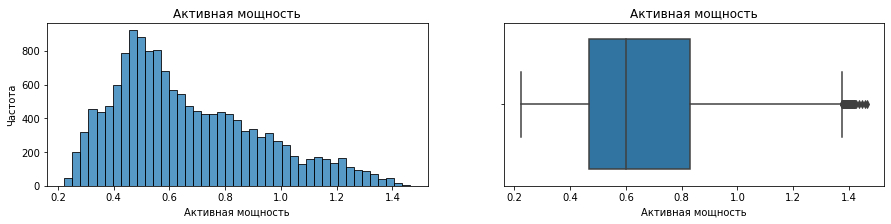

In [90]:
plot_col(df_arc, 'Активная мощность')

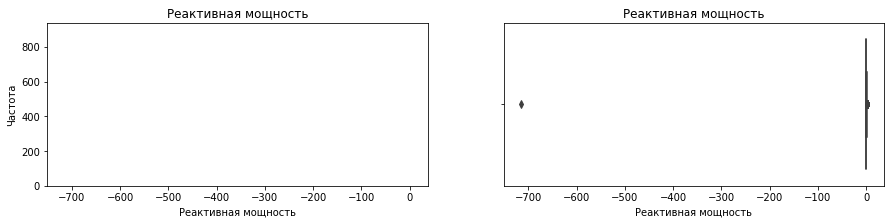

In [91]:
plot_col(df_arc, 'Реактивная мощность')

Обнаружен выброс в реактивной мощности. Удалим его.

In [92]:
df_arc.loc[df_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


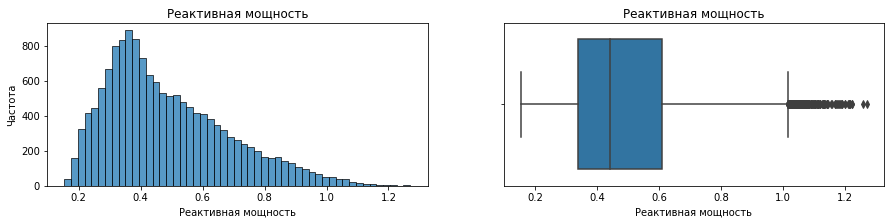

In [93]:
df_arc = df_arc.loc[df_arc['key'] != 2116]
plot_col(df_arc, 'Реактивная мощность')

Создадим новые признаки в данной таблице:
- Полная мощность. Из физики известно, что $ \text{Полная мощность} = \sqrt{\text{Активная}^2 + \text{Реактивная}^2} $;
- Время нагрева дугой. Разница между Начало нагрева дугой и Конец нагрева дугой;
- Электроэнергия. Количество полной мощности, которое ушло на нагрев. 

In [94]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_arc['Полная мощность'] = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)
df_arc['Время нагрева дугой'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).astype('timedelta64[s]')
df_arc['Электроэнергия'] = df_arc['Полная мощность'] * df_arc['Время нагрева дугой']

In [95]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Электроэнергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0,159.830252


Объедим записи по уникальным партиям, суммировав затраченную электроэнергию и усредняя мощность.

In [96]:
df_arc = df_arc.groupby('key').agg({'key': 'count', 'Начало нагрева дугой': 'min',
                                   'Конец нагрева дугой': 'max',
                                   'Активная мощность': 'mean',
                                   'Реактивная мощность': 'mean',
                                   'Полная мощность': 'mean',
                                   'Время нагрева дугой': 'sum',
                                   'Электроэнергия' : 'sum'})

df_arc_time = df_arc[['Начало нагрева дугой', 'Конец нагрева дугой']]
df_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1, inplace=True)
df_arc = df_arc.rename(columns={'key': 'Количество циклов нагрева'})

In [97]:
first_size = len(df_arc)
df_arc.head()

,Количество циклов нагрева,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Электроэнергия
key,,,,,,
1,5,0.607346,0.428564,0.743747,1098.0,770.282114
2,4,0.534852,0.363339,0.647087,811.0,481.760005
3,5,0.812728,0.587491,1.003845,655.0,722.837668
4,4,0.676622,0.514248,0.850010,741.0,683.455597
5,4,0.563238,0.421998,0.704245,869.0,512.169934


count    3213.000000
mean      794.691566
std       332.439136
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: Время нагрева дугой, dtype: float64


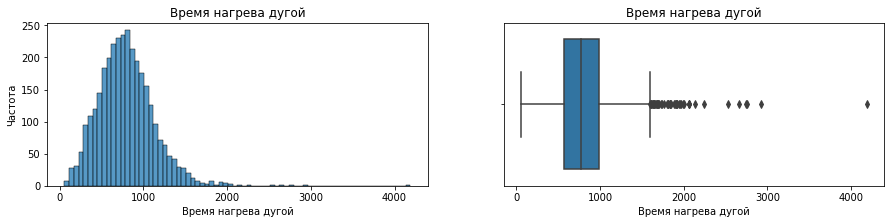

In [98]:
print(df_arc['Время нагрева дугой'].describe())
plot_col(df_arc, 'Время нагрева дугой')

Обнаружены выбросы. Ограничим значения.

In [99]:
df_arc = df_arc.loc[df_arc['Время нагрева дугой'] < 2000]

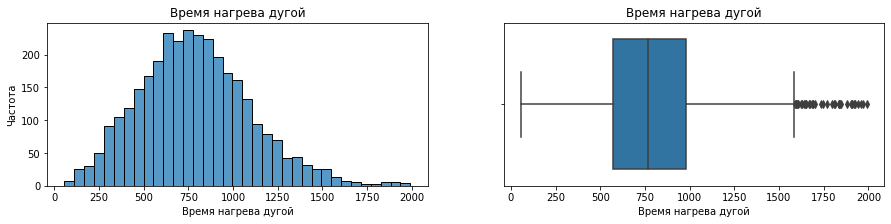

In [100]:
plot_col(df_arc, 'Время нагрева дугой')

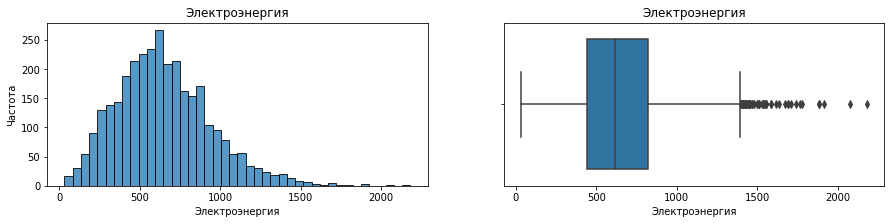

In [101]:
plot_col(df_arc, 'Электроэнергия')

Обнаружены выбросы. Ограничим значения.

In [102]:
df_arc = df_arc.loc[df_arc['Электроэнергия'] < 2000]

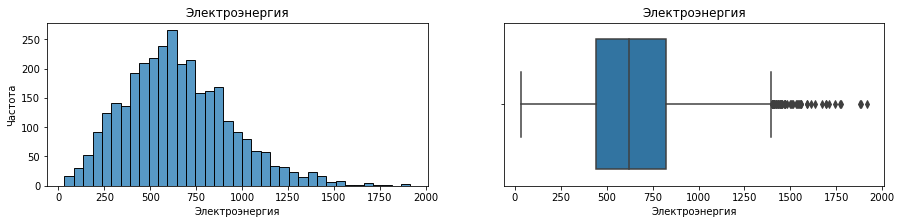

In [103]:
plot_col(df_arc, 'Электроэнергия')

### data_bulk_new

Заполним пропущенные значения нулями (см. вывод из п.4). Создадим новый признак общего объема сыпучего материала, добавленного в расплав.

In [104]:
df_bulk = df_bulk.fillna(0).astype(int)
df_bulk['Bulk sum'] = df_bulk.sum(axis=1)

In [105]:
df_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk sum
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,554
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,584
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,547
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,599
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,589
5,6,0,0,0,117,0,0,0,0,0,0,0,204,0,201,154,682
6,7,0,0,0,117,0,0,0,0,0,0,0,204,0,152,154,634
7,8,0,0,0,99,0,0,0,0,0,0,0,410,0,252,153,922
8,9,0,0,0,117,0,0,0,0,0,0,0,107,0,99,203,535
9,10,0,0,0,0,0,0,0,0,0,0,0,203,0,102,204,519


### data_temp_new

In [106]:
df_temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

Обнаружены пропуски в значениях температуры. По условию необходимо удалить все замеры, если в ряде присутствует хотя бы один пропуск.

In [107]:
ind_to_del = df_temp[df_temp['Температура'].isna()]['key'].unique()
df_temp = df_temp.loc[~df_temp['key'].isin(ind_to_del)]

In [108]:
df_temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

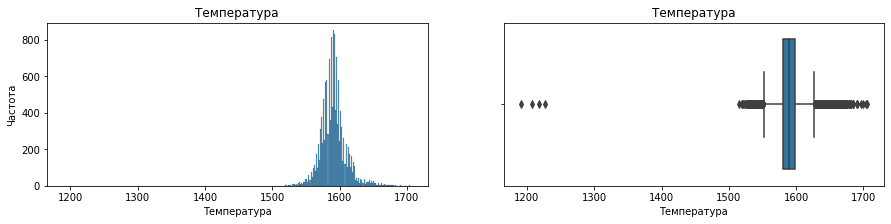

In [109]:
plot_col(df_temp, 'Температура')

Обнаружены выбросы. Избавимся от них. Сопоставим начальные и последние температуры и удалим те записи, где минимальная температура опускалась ниже установленного стандарта.

In [110]:
df_temp_temp = df_temp.copy()
df_temp_temp['Начальная температура'] = df_temp_temp['Температура']
df_temp_temp['Минимальная температура'] = df_temp_temp['Температура']
df_temp_temp['Последняя температура'] = df_temp_temp['Температура']
df_temp_temp = df_temp_temp.groupby('key').agg({'Начальная температура' : 'first', 
                                             'Минимальная температура' : 'min', 
                                             'Последняя температура' : 'last'})

df_temp_temp = df_temp_temp.loc[df_temp_temp['Минимальная температура'] > 1500]
df_temp_temp

,Начальная температура,Минимальная температура,Последняя температура
key,,,
1,1571.0,1571.0,1613.0
2,1581.0,1577.0,1602.0
3,1596.0,1596.0,1599.0
4,1601.0,1601.0,1625.0
5,1576.0,1576.0,1602.0
...,...,...,...
2495,1570.0,1570.0,1591.0
2496,1554.0,1554.0,1591.0
2497,1571.0,1571.0,1589.0


In [111]:
df_temp_temp.isna().sum()

Начальная температура      0
Минимальная температура    0
Последняя температура      0
dtype: int64

Последняя температура является целевым признаком по условию. Отметим время первого и последнего замера температуры.

In [112]:
df_temp_time = df_temp.copy()
df_temp_time['Время начального замера температуры'] = df_temp_time['Время замера']
df_temp_time['Время последнего замера температуры'] = df_temp_time['Время замера']
df_temp_time = df_temp_time.groupby('key').agg({'Время начального замера температуры' : 'first', 
                                                'Время последнего замера температуры' : 'last'})
df_temp_time.head()

,Время начального замера температуры,Время последнего замера температуры
key,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38
2,2019-05-03 11:34:04,2019-05-03 11:55:09
3,2019-05-03 12:06:44,2019-05-03 12:35:57
4,2019-05-03 12:39:27,2019-05-03 12:59:47
5,2019-05-03 13:11:03,2019-05-03 13:36:39


In [113]:
df_temp_time.isna().sum()

Время начального замера температуры    0
Время последнего замера температуры    0
dtype: int64

### data_wire_new

In [114]:
df_wire = df_wire.fillna(0)
df_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Вывод
- Пропуски заполнены нулями;
- Обнаружены пропуски в значениях температуры. По условию необходимо удалить все замеры, если в ряде присутствует хотя бы один пропуск;
- Удалены выбросы;
- Созданы новые признаки: Полная мощность, Время нагрева дугой, Электроэнергия, Количество циклов нагрева, Bulk sum, Начальная температура, Минимальная температура, Время начального замера температуры, Время последнего замера температуры;
- Выделен целевой признак - Последняя температура.

<a id='section3'></a> 
## Объединение данных

In [115]:
df = df_arc
for data in [df_bulk, df_gas, df_temp_temp, df_wire]:
    df = df.merge(data, on=['key'])
df.head()

,key,Количество циклов нагрева,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Электроэнергия,Bulk 1,Bulk 2,Bulk 3,...,Последняя температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,0.607346,0.428564,0.743747,1098.0,770.282114,0,0,0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,4,0.534852,0.363339,0.647087,811.0,481.760005,0,0,0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,0.812728,0.587491,1.003845,655.0,722.837668,0,0,0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,4,0.676622,0.514248,0.850010,741.0,683.455597,0,0,0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4,0.563238,0.421998,0.704245,869.0,512.169934,0,0,0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
df_time = df_temp_time
for data in [df_arc_time, df_bulk_time, df_wire_time]:
    df_time = df_time.merge(data, on=['key'], how='inner')
    
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 0 to 2329
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   key                                  2330 non-null   int64         
 1   Время начального замера температуры  2330 non-null   object        
 2   Время последнего замера температуры  2330 non-null   object        
 3   Начало нагрева дугой                 2330 non-null   datetime64[ns]
 4   Конец нагрева дугой                  2330 non-null   datetime64[ns]
 5   Bulk 1                               199 non-null    object        
 6   Bulk 2                               13 non-null     object        
 7   Bulk 3                               960 non-null    object        
 8   Bulk 4                               813 non-null    object        
 9   Bulk 5                               53 non-null     object        
 10  Bulk 6      

In [122]:
if len(df['key'].unique()) <= 2332:
    print("Данные обработаны и объединены верно.")
else:
    print("Ошибка в решении.")

Данные обработаны и объединены верно.


In [117]:
df_time['Время последнего замера температуры'] = pd.to_datetime(df_time['Время последнего замера температуры'])
df_time['Время начального замера температуры'] = pd.to_datetime(df_time['Время начального замера температуры'])
df_time['Конец нагрева дугой'] = pd.to_datetime(df_time['Конец нагрева дугой'])
df_time['Начало нагрева дугой'] = pd.to_datetime(df_time['Начало нагрева дугой'])
for i in range(1, 16):
    df_time['Bulk ' + str(i)] = pd.to_datetime(df_time['Bulk ' + str(i)])
for i in range(1, 10):
    df_time['Wire ' + str(i)] = pd.to_datetime(df_time['Wire ' + str(i)])

In [118]:
df_time.head()

,key,Время начального замера температуры,Время последнего замера температуры,Начало нагрева дугой,Конец нагрева дугой,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,2019-05-03 11:02:14,2019-05-03 11:28:37,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,...,2019-05-03 11:10:43,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,2019-05-03 11:34:14,2019-05-03 11:53:18,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,...,2019-05-03 11:44:39,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,2019-05-03 12:06:54,2019-05-03 12:32:19,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,...,2019-05-03 12:16:16,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,2019-05-03 12:39:37,2019-05-03 12:57:50,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,...,2019-05-03 12:46:36,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,2019-05-03 13:11:13,2019-05-03 13:33:55,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,...,2019-05-03 13:30:47,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


По условию операция измерения температуры в начале и в конце каждого этапа должны быть соответсвенно первой и последней операцией. Удалим те партии, которые не соответствуют условию.

In [119]:
columns = df_time.select_dtypes('datetime').columns
df_time = df_time[(df_time['Время последнего замера температуры'] >= df_time[columns].max(axis=1))]
df_time = df_time[(df_time['Время начального замера температуры'] <= df_time[columns].min(axis=1))]

In [120]:
print(f"В процессе обработки было удалено {round((first_size - len(df.merge(df_time, on=['key']))) / first_size * 100, 2)}% исходных данных")

В процессе обработки было удалено 28.07% исходных данных


### Вывод:
- Данные объединены в 2 таблицы проведения работ по времени и по тратам;
- Корректность операций по замеру температуры в начале и в конце каждого этапа учтена;
- По завершению этапа предобработки были удалены 28.07% исходных данных.

<a id='section4'></a> 
## Исследовательский анализ и предобработка данных объединённого датафрейма

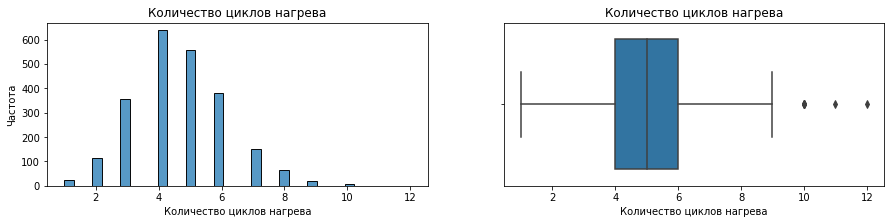

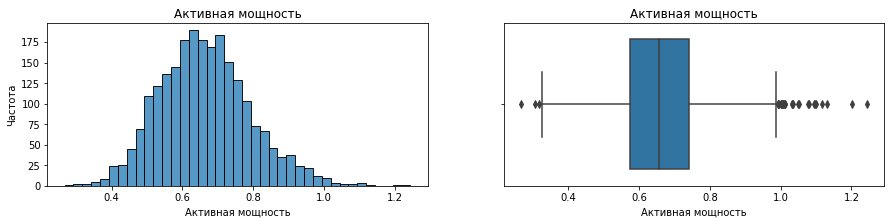

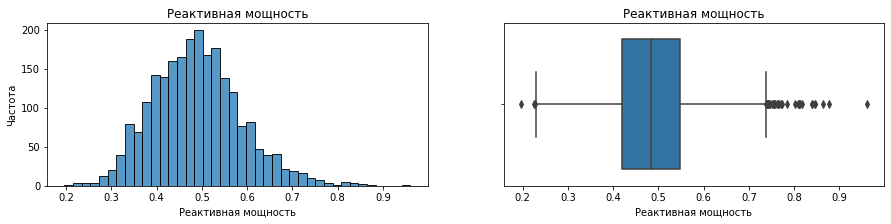

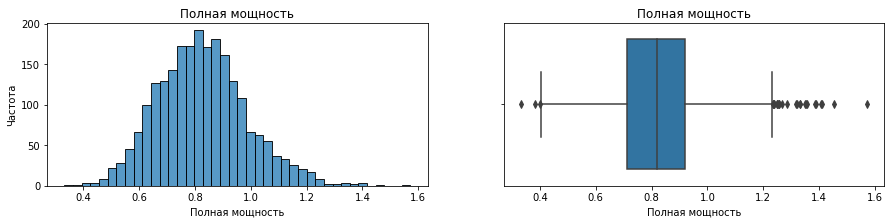

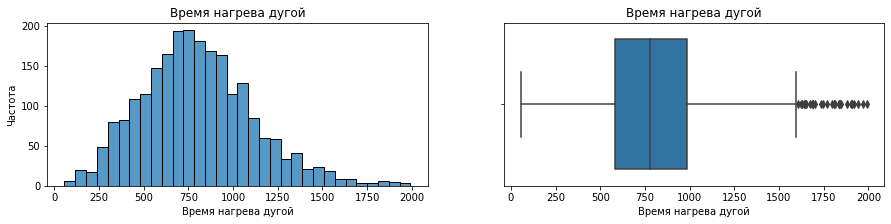

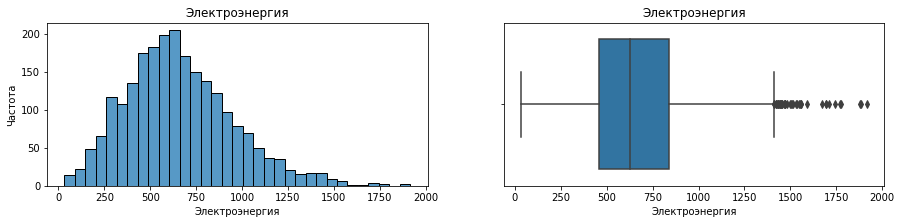

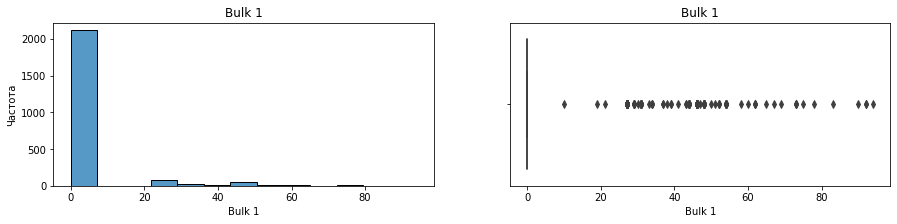

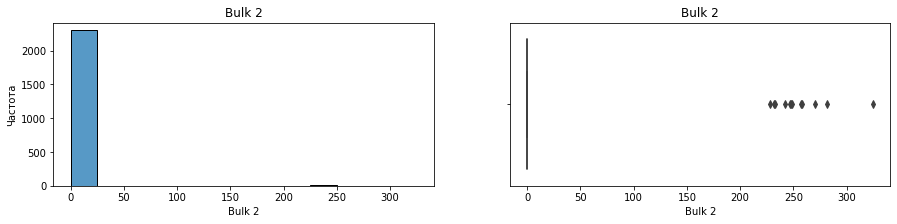

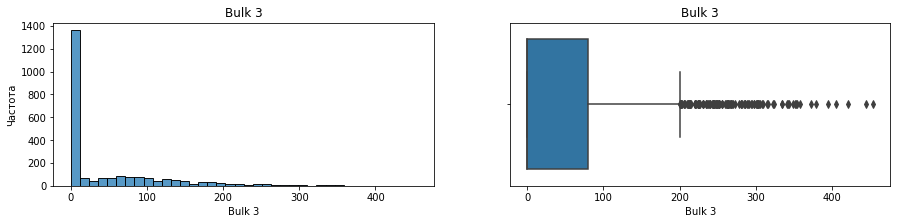

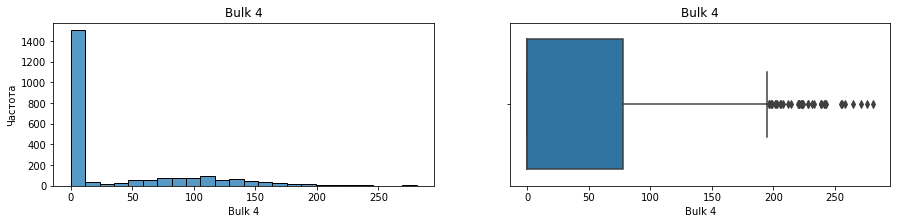

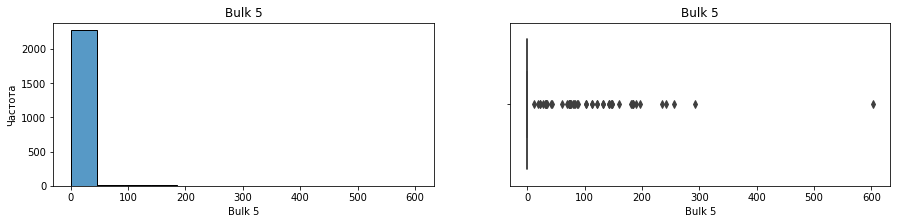

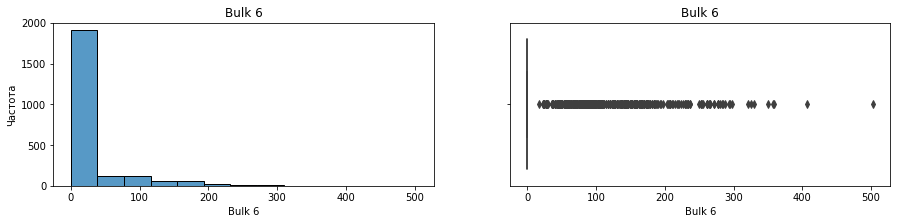

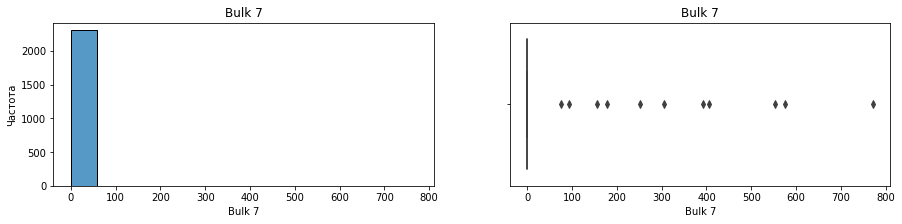

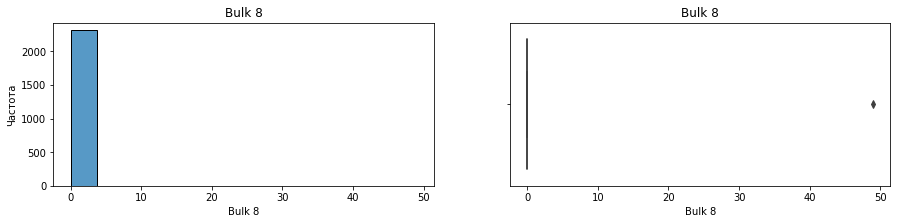

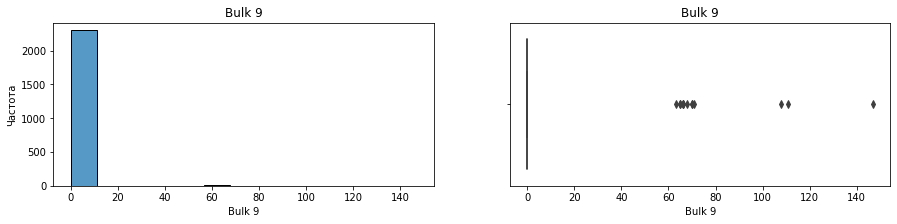

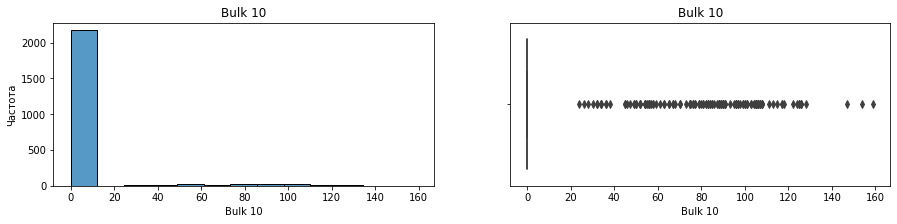

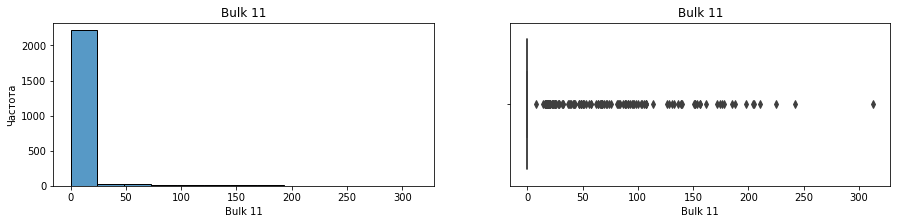

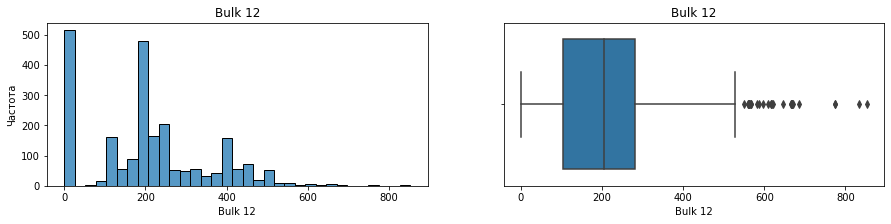

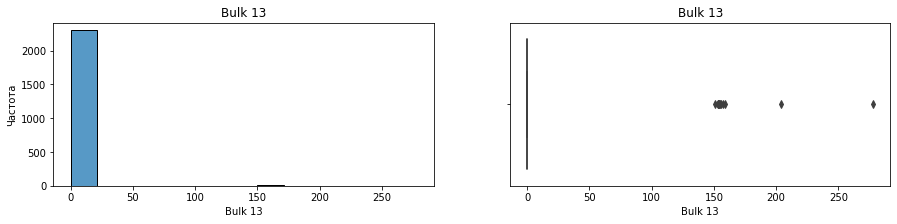

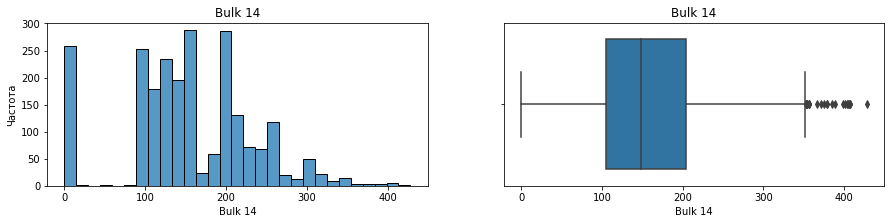

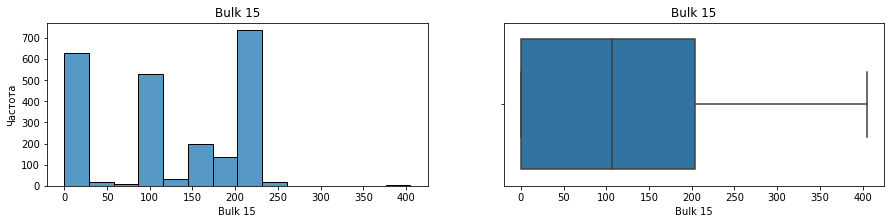

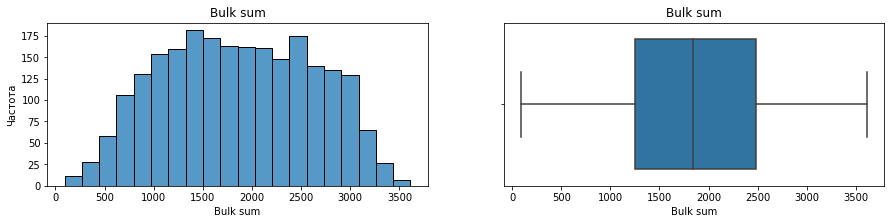

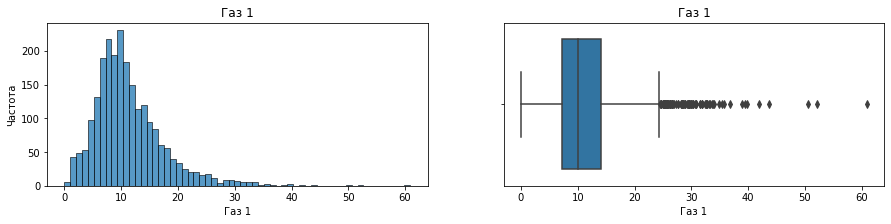

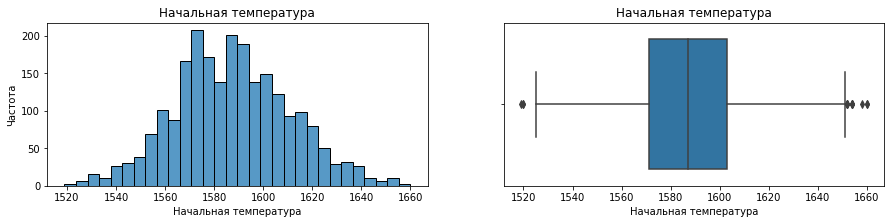

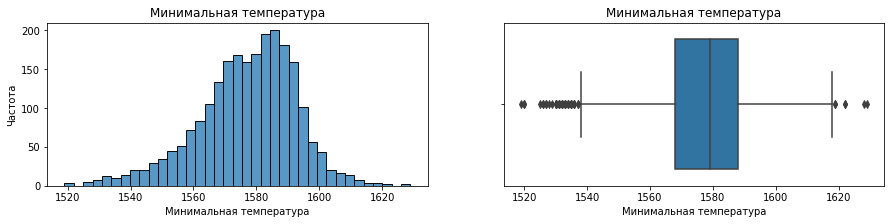

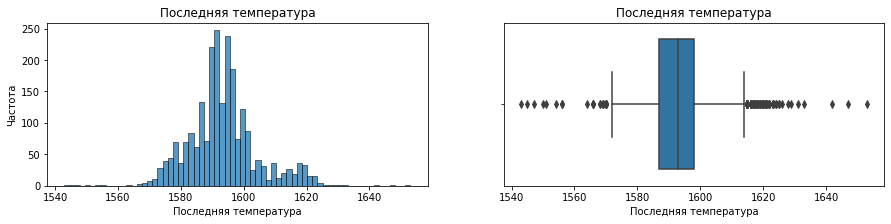

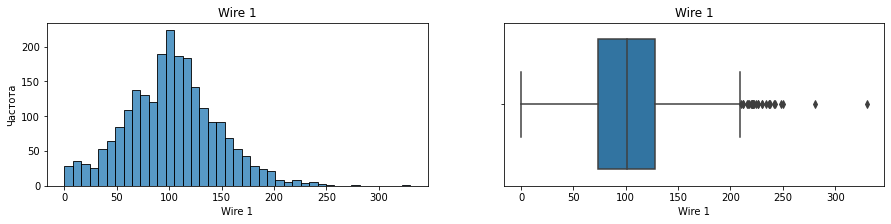

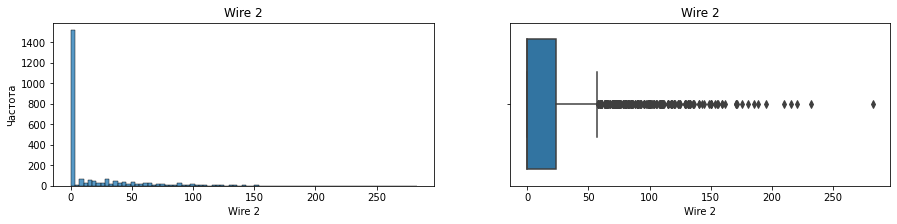

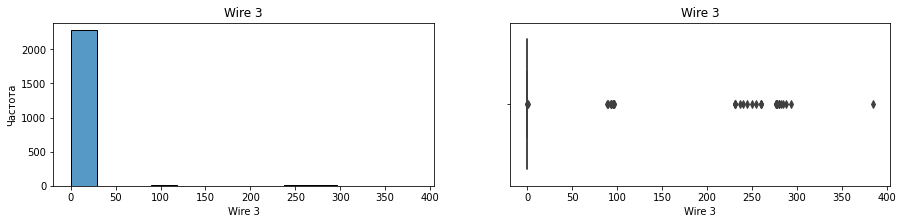

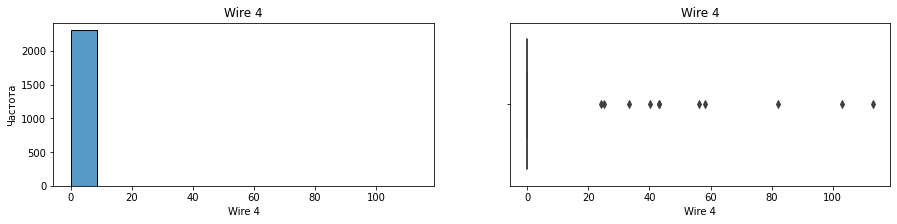

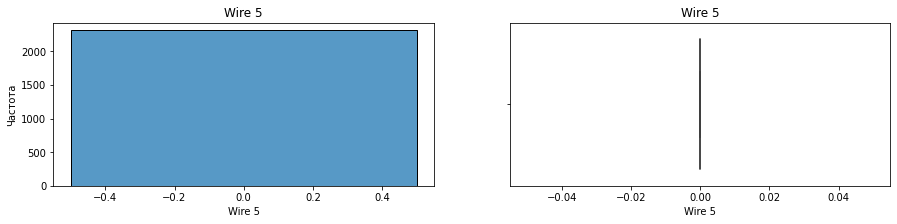

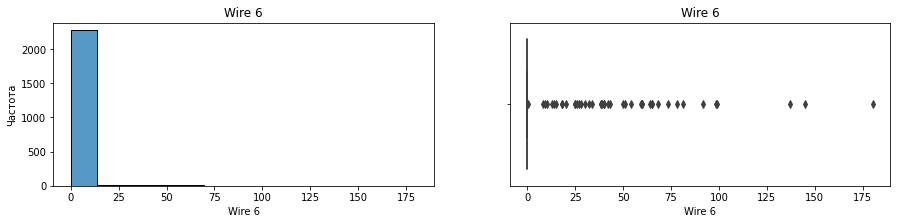

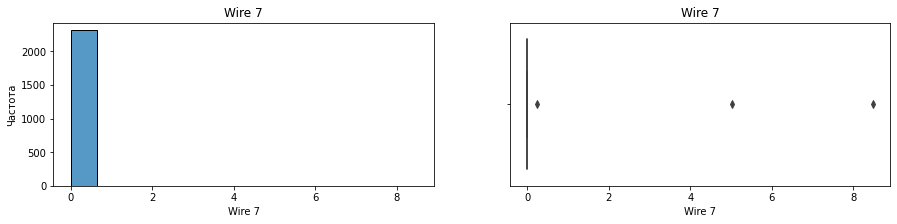

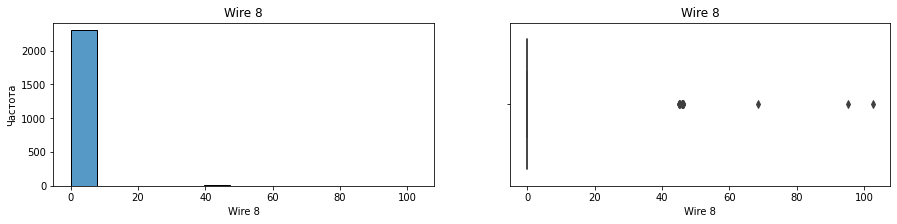

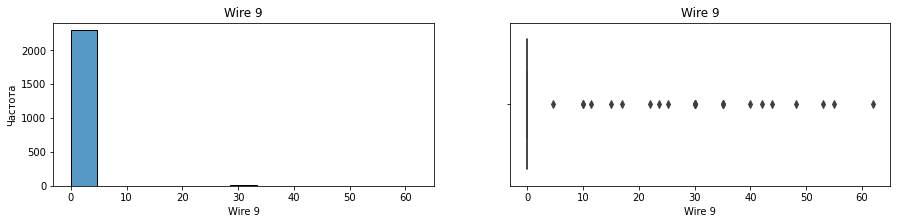

In [129]:
features = ['Количество циклов нагрева', 'Активная мощность', 'Реактивная мощность', 'Полная мощность', 'Время нагрева дугой',
            'Электроэнергия', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 
            'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Bulk sum', 'Газ 1', 'Начальная температура', 
            'Минимальная температура', 'Последняя температура', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 
            'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
for i in features:
    plot_col(df, i)
    

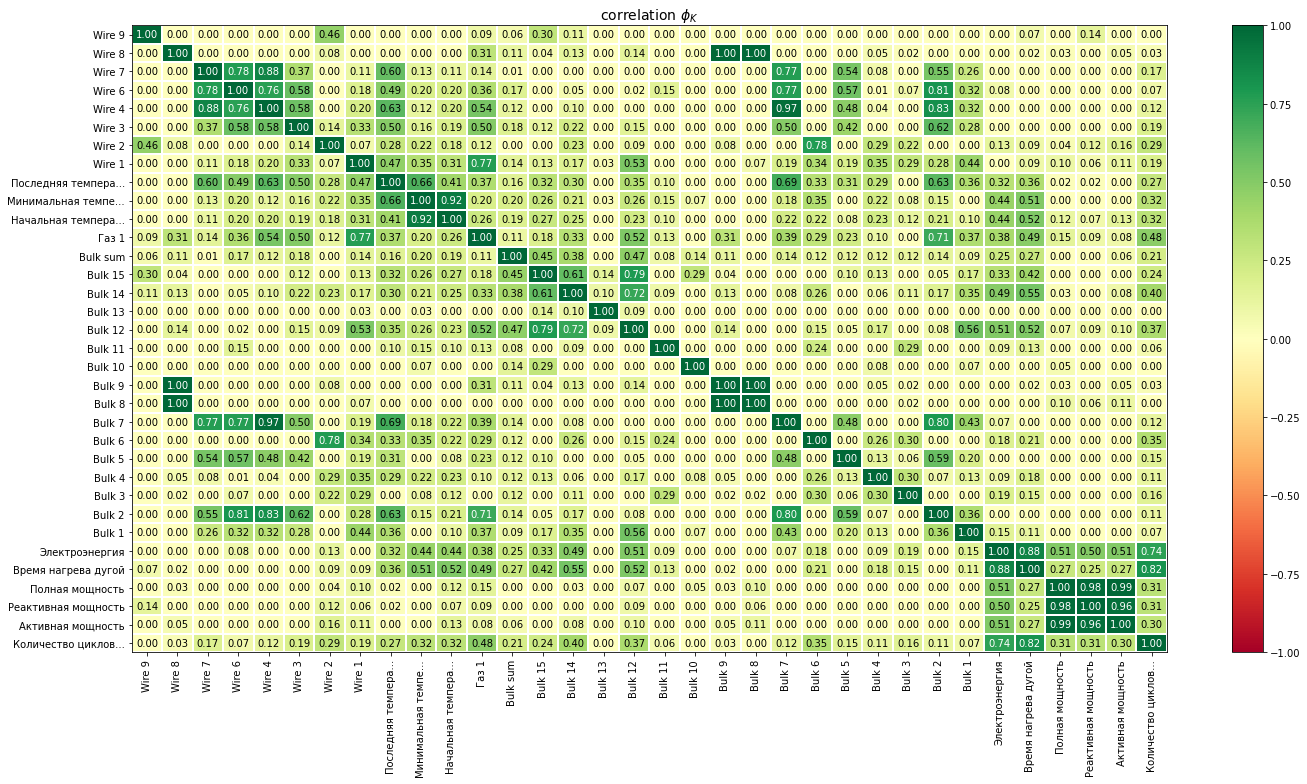

In [131]:
phik_overview = df.drop(['key'], axis=1).phik_matrix(interval_cols=['Последняя температура', 'Количество циклов нагрева',\
'Активная мощность', 'Реактивная мощность', 'Полная мощность', 'Время нагрева дугой', 'Электроэнергия', 'Bulk 1', 'Bulk 2',\
'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14',\
'Bulk 15', 'Bulk sum', 'Газ 1', 'Начальная температура', 'Минимальная температура', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',\
'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1,
    figsize=(20, 11)
)

In [132]:
col_del = ['Wire 8', 'Bulk 8', 'Bulk 9', 'Wire 5', 'Минимальная температура', 'Полная мощность', 'Реактивная мощность', 'key']

### Вывод:
- Построена таблица корреляции методом phik;
- В данном случае, значения >0.9 принимаем за высокую корреляцию;
- Выделены столбцы для удаления: 'Wire 8', 'Bulk 8', 'Bulk 9', 'Wire 5', 'Полная мощность', 'Реактивная мощность'.

<a id='section5'></a> 
## Подготовка данных

In [133]:
df = df.drop(col_del, axis=1)

X = df.drop('Последняя температура', axis=1)
y = df['Последняя температура']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [135]:
X_train.shape

(1733, 27)

In [137]:
X_test.shape

(578, 27)

### Вывод:
- Данные разделены на обучающую и тестовую выборки в пропорции 75/25;
- В обучающей выборке более 1700 элементов, что соответствует требованию заказчика.

<a id='section6'></a> 
## Обучение моделей машинного обучения

### LinearRegression

In [66]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)

In [67]:
model = LinearRegression()
mae_lr = round(abs(cross_val_score(model, X=X_train_scaler, y=y_train, cv=5, scoring='neg_mean_absolute_error')).mean(), 2)
print('MAE LinearRegression:', mae_lr)

MAE LinearRegression: 8.86


### RandomForestRegressor

In [68]:
params = {'n_estimators': [10, 50, 100],
          'max_depth': [20, 25, 30],
          'min_samples_split': [2, 3, 4]}

model_rf = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), params, cv=5, scoring='neg_mean_absolute_error')
model_rf.fit(X_train, y_train)
print('Best params RandomForestRegressor', model_rf.best_params_)

Best params RandomForestRegressor {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}


In [69]:
mae_rf = round(abs(model_rf.best_score_), 2)
print('MAE RandomForestRegressor:', mae_rf)

MAE RandomForestRegressor: 6.05


### LGBMRegressor

In [70]:
params = {'learning_rate':[0.03, 0.04, 0.05, 0.06, 0.07], 
          'max_depth': [15, 16, 17]}

model_lgbmr = GridSearchCV(LGBMRegressor(random_state=RANDOM_STATE), params, scoring='neg_mean_absolute_error')
model_lgbmr.fit(X_train, y_train)
print('Best params LGBMRegressor', model_lgbmr.best_params_)

Best params LGBMRegressor {'learning_rate': 0.05, 'max_depth': 17}


In [71]:
mae_lgbmr = round(abs(model_lgbmr.best_score_), 2)
print('MAE RandomForestRegressor:', mae_lgbmr)

MAE RandomForestRegressor: 6.04


### DummyRegressor

In [72]:
model_dr = DummyRegressor()
model_dr.fit(X_train, y_train)
y_pred = model_dr.predict(X_test)

mae_dr = round(abs(mae(y_pred, y_test)), 2)
print('MAE DummyRegressor:', mae_dr)

MAE DummyRegressor: 10.57


### Вывод:
- Обучены 4 модели: LinearRegression, RandomForestRegressor, LGBMRegressor, DummyRegressor;
- Каждая модель, кроме константной, обучена на кроссвалидации;
- Там, где это возможно, подобраны значения параметров.

<a id='section7'></a> 
## Выбор лучшей модели

In [73]:
pd.DataFrame(data={'MAE train':[mae_lr, mae_rf, mae_lgbmr, mae_dr]}, 
             index=['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'DummyRegressor']).sort_values(by='MAE train')

,MAE train
LGBMRegressor,6.04
RandomForestRegressor,6.05
LinearRegression,8.86
DummyRegressor,10.57


In [74]:
best_model = LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.05, max_depth=17)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [75]:
test_mae = round(abs(mae(y_pred, y_test)), 2)
print('Test MAE:', test_mae)

Test MAE: 5.86


In [76]:
importances = pd.DataFrame(data={'Attribute': X_train.columns,
                                 'Importance': best_model.feature_importances_ })
importances = importances.sort_values(by='Importance', ascending=False)

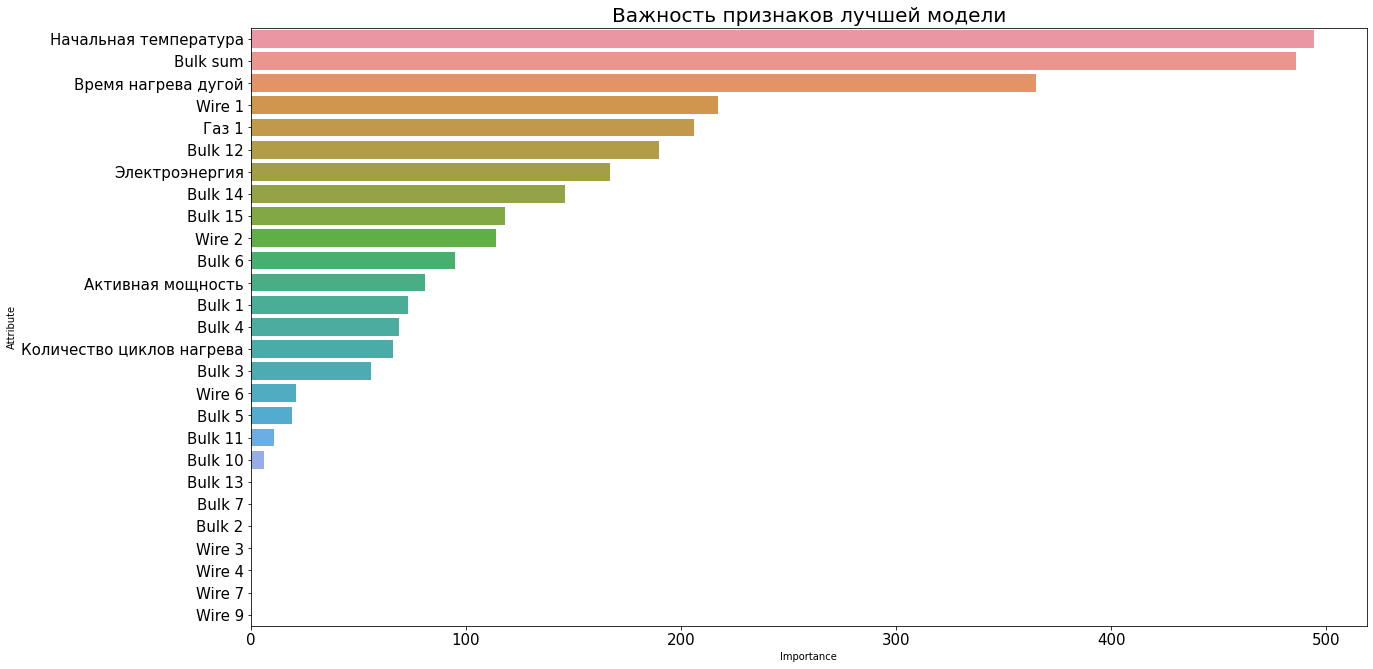

In [77]:
plt.figure(figsize=(20, 11))
sns.barplot(y=importances['Attribute'], x=importances['Importance'], orient="h")
plt.title("Важность признаков лучшей модели", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

Наибольшее влияние на предсказанные данные последней температуры имеют следующие признаки: Начальная температура, общий объем добавленного сыпучего материала и время нагрева дугой. Другими словами, чем выше значения данных признаков, тем выше значения конечной температуры и наоборот.

### Вывод:
- Лучшая модель: LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.05, max_depth=17);
- МАЕ на тестовой выборке: 5.86;
- Построен график важности признаков исходной модели;
- Интерпретация графика: Наибольшее влияние на предсказанные данные последней температуры имеют следующие признаки: Начальная температура, Общий объем добавленного сыпучего материала (Bulk sum) и Время нагрева дугой. Другими словами, чем выше значения данных признаков, тем выше значения конечной температуры и наоборот.

<a id='section8'></a> 
## Общий вывод и рекомендации заказчику



- Загрузка данных:
    - Данные загружены. Создано 7 таблиц. Столбцы не переименовывались;
    - data_bulk_new, data_bulk_time_new, data_wire_new, data_wire_time_new содержат пропуски, что свидетельствует об отсутсвии использования определенного материала в технологическом процессе. Целесообразно заполнить пропуски нулями;
    - Явные дубликаты отсутствуют.
- Исследовательский анализ и предобработка данных:
    - Пропуски заполнены нулями;
    - Удалены выбросы;
    - Созданы новые признаки: Полная мощность, Время нагрева дугой, Электроэнергия, Количество циклов нагрева, Bulk sum, Начальная температура, Минимальная температура, Время начального замера температуры, Время последнего замера температуры;
    - Выделен целевой признак - Последняя температура.
- Объединение данных:
    - Данные объединены в 2 таблицы проведения работ по времени и по тратам;
    - Корректность операций по замеру температуры в начале и в конце каждого этапа учтена;
    - По завершению этапа предобработки были удалены 28.07% исходных данных.
- Исследовательский анализ и предобработка данных объединённого датафрейма:
    - Построена таблица корреляции методом phik;
    - В данном случае, значения >0.9 принимаем за высокую корреляцию;
    - Выделены столбцы для удаления: 'Wire 8', 'Bulk 8', 'Bulk 9', 'Wire 5', 'Полная мощность', 'Реактивная мощность'.
- Подготовка данных:
    - Данные разделены на обучающую и тестовую выборки в пропорции 75/25.
- Обучение моделей машинного обучения:
    - Обучены 4 модели: LinearRegression, RandomForestRegressor, LGBMRegressor, DummyRegressor;
    - Каждая модель, кроме константной, обучена на кроссвалидации;
    - Там, где это возможно, подобраны значения параметров.
- Выбор лучшей модели:
    - Лучшая модель: LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.05, max_depth=17);
    - МАЕ на тестовой выборке: 5.86;
    - Построен график важности признаков исходной модели;
    - Интерпретация графика: Наибольшее влияние на предсказанные данные последней температуры имеют следующие признаки: Начальная температура, общий объем добавленного сыпучего материала и время нагрева дугой. Другими словами, чем выше значения данных признаков, тем выше значения конечной температуры и наоборот.
- Рекомендации заказчику:
    - Основные значимые признаки для этой модели были новыми добавленными признаками;
    - Обученная модель LGBMRegressor с подобранными гиперпараметрами рекомендована к использованию для прогнозирования температуры стали.